Image registration to create a pixel map between top camera (A) and quadrant camera (B) with overlapping fields of view (FOV), where quadtant camera's FOV is a subset and a rotated version of top camera's FOV. 
1. Exrtact and Load Images: Extract random matching frames from the video frames for both Camera A and Camera B and load them. Use multiple images to get moe accurate map.
2. Detect Features: Use ORB (Oriented FAST and Rotated BRIEF) to detect keypoints and get descriptors. 
3. Match Features: Use a matcher (rute-Force matcher with Hamming distance) to find corresponding keypoints between the images. Keep best matches.
4. Compute Homography: Estimate the homography matrix (matrix that best transforms the matched keypoints from Camera B's frame of reference to Camera A's frame of reference) to align the images (rotation, translation, scaling).
5. Warp Images: Apply the homography to transform Camera B's images to align with Camera A's perspective.
6. Pixel map: Get the pixel map from A to B and vice versa based on this.
7. Quality checks base on homography matrix.
8. Multi-frame averaging: Perform these computation on many frames and average over individual homography matrices that pass checks for more accurate results.
9. Visualise results.


This method seems to work better then other tried, becasue:

- can deal with low number of unique features in the image (feature matching algorithms failed)
- can deal with orientation and perspective differences (template matching (= find B within A) failed)

In [1]:
"""Notebook settings and imports"""

%load_ext autoreload
%autoreload 2

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
"""File paths (example: CameraTop and multiple CameraB)"""

camera_a = 'CameraTop'
camera_b_list = ['CameraSouth', 'CameraNorth', 'CameraEast', 'CameraWest']

# Define base path and video path
base_path = '/ceph/aeon/aeon'
video_path = base_path + '/data/raw/AEON3/social0.2/2024-01-31T11-28-39'
video_path_a = video_path + f'/{camera_a}/{camera_a}_2024-01-31T11-00-00.avi'

# Define image output directory
output_dir = base_path + '/code/scratchpad/Orsi/pixel_mapping/example_frames'
os.makedirs(output_dir, exist_ok=True)

# 1. Load frames

In [3]:
"""Extract some frames from videos and save them as images"""

number_of_frames = 20

# Function to get total number of frames in a video
def get_total_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

# Function to extract and save frames
def extract_and_save_frames(video_path, frame_indices, prefix):
    cap = cv2.VideoCapture(video_path)
    for i, frame_idx in enumerate(frame_indices):
        frame_filename = os.path.join(output_dir, f'{prefix}_frame_{i}.png')
        if not os.path.exists(frame_filename):  # Check if frame already exists
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                cv2.imwrite(frame_filename, frame)
    cap.release()

# Check if there are already number_of_frames frames saved for camera_a
existing_frames_a = [f for f in os.listdir(output_dir) if f.startswith(f'{camera_a}_frame_')]

if len(existing_frames_a) >= number_of_frames:
    print(f"Frames already exist for {camera_a}. No new frames will be saved.")
else:
    # Get total number of frames in the video for camera_a
    total_frames_a = get_total_frames(video_path_a)

    # Randomly select number_of_frames frame indices
    random_frame_indices = random.sample(range(total_frames_a), number_of_frames)
    print(random_frame_indices)

    # Extract and save frames from camera_a
    extract_and_save_frames(video_path_a, random_frame_indices, f'{camera_a}')

    print(f"Extracted frames saved to {output_dir} for {camera_a}")

# Loop through each camera in camera_b_list
for camera_b in camera_b_list:
    video_path_b = video_path + f'/{camera_b}/{camera_b}_2024-01-31T11-00-00.avi'

    # Check if there are already number_of_frames frames saved for camera_b
    existing_frames_b = [f for f in os.listdir(output_dir) if f.startswith(f'{camera_b}_frame_')]

    if len(existing_frames_b) >= number_of_frames:
        print(f"Frames already exist for {camera_b}. No new frames will be saved.")
        continue

    # Get total number of frames in the video for camera_b
    total_frames_b = get_total_frames(video_path_b)

    # Ensure both videos have the same number of frames
    assert total_frames_a == total_frames_b, f"Videos for {camera_a} and {camera_b} do not have the same number of frames."

    # Extract and save frames from camera_b
    extract_and_save_frames(video_path_b, random_frame_indices, f'{camera_b}')

    print(f"Extracted frames saved to {output_dir} for {camera_b}")

Frames already exist for CameraTop. No new frames will be saved.
Frames already exist for CameraSouth. No new frames will be saved.
Frames already exist for CameraNorth. No new frames will be saved.
Frames already exist for CameraEast. No new frames will be saved.
Frames already exist for CameraWest. No new frames will be saved.


# 2. Image registration

Passed perspective check
Rotation: 357.85025937145684 Expected: 0
Passed rotation check
Passed shear check
Valid Homography found for frame /ceph/aeon/aeon/code/scratchpad/Orsi/pixel_mapping/example_frames/CameraWest_frame_0.png
Failed perspective check
Invalid Homography found for frame /ceph/aeon/aeon/code/scratchpad/Orsi/pixel_mapping/example_frames/CameraWest_frame_1.png
Failed perspective check
Invalid Homography found for frame /ceph/aeon/aeon/code/scratchpad/Orsi/pixel_mapping/example_frames/CameraWest_frame_2.png
Failed perspective check
Invalid Homography found for frame /ceph/aeon/aeon/code/scratchpad/Orsi/pixel_mapping/example_frames/CameraWest_frame_3.png
Passed perspective check
Rotation: 205.10945589679065 Expected: 0
Failed rotation check
Invalid Homography found for frame /ceph/aeon/aeon/code/scratchpad/Orsi/pixel_mapping/example_frames/CameraWest_frame_4.png
Passed perspective check
Rotation: 357.426133563188 Expected: 0
Passed rotation check
Passed shear check
Valid H

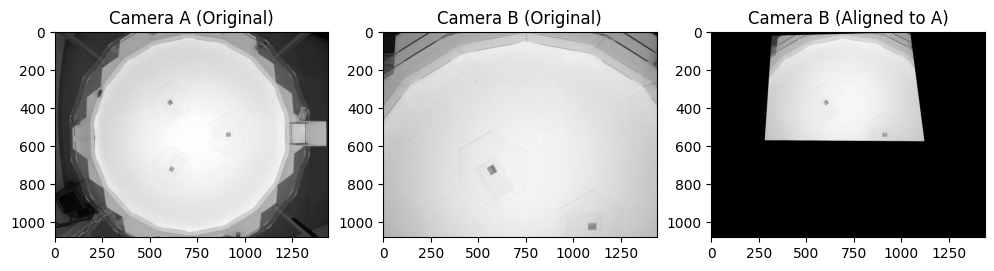

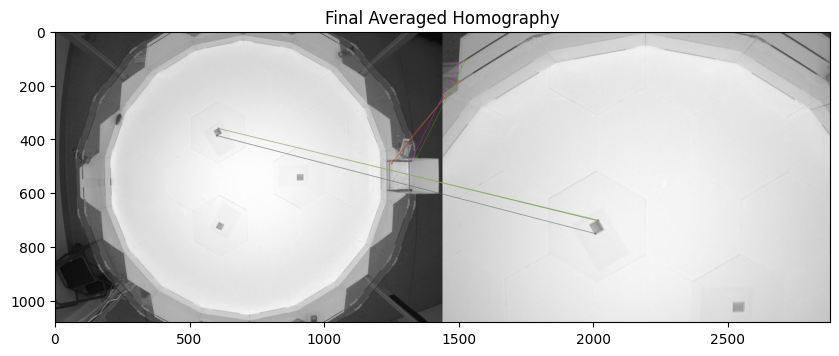

In [25]:
def load_images(camera_a_frame_path, camera_b_frame_path):
    """
    Load images from the given paths.
    """
    img_a = cv2.imread(camera_a_frame_path, cv2.IMREAD_GRAYSCALE)
    img_b = cv2.imread(camera_b_frame_path, cv2.IMREAD_GRAYSCALE)
    return img_a, img_b

def detect_and_match_features(img_a, img_b, nfeatures=1000):
    """
    Detect and match features between two images using ORB.
    """
    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=nfeatures)

    # Detect keypoints and descriptors
    kp_a, des_a = orb.detectAndCompute(img_a, None)
    kp_b, des_b = orb.detectAndCompute(img_b, None)

    # Match features using the Brute-Force matcher with Hamming distance
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_a, des_b)
    matches = sorted(matches, key=lambda x: x.distance)  # Sort matches by distance

    return kp_a, kp_b, matches

def compute_homography(kp_a, kp_b, matches):
    """
    Compute the homography matrix to map Image B to Image A.
    """
    # Extract matched keypoints
    src_pts = np.float32([kp_b[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_a[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, mask

def warp_image(img_b, H, img_a_shape):
    """
    Warp Image B to Image A's perspective using the homography matrix.
    """
    # Apply homography to warp Image B
    img_b_aligned = cv2.warpPerspective(img_b, H, (img_a_shape[1], img_a_shape[0]))
    return img_b_aligned

def plot_results(img_a, img_b, img_b_aligned, kp_a, kp_b, matches, mask, title):
    """
    Plot the original and aligned images, and matched features with each match in a different color.
    """
    # Generate different colors for each match line
    colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in matches]

    # Draw matches
    img_matches = cv2.drawMatches(img_a, kp_a, img_b, kp_b, matches, None, 
                                  matchColor=None, singlePointColor=None, 
                                  matchesMask=mask.ravel().tolist(), flags=2)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_a, cmap='gray')
    plt.title("Camera A (Original)")

    plt.subplot(1, 3, 2)
    plt.imshow(img_b, cmap='gray')
    plt.title("Camera B (Original)")

    plt.subplot(1, 3, 3)
    plt.imshow(img_b_aligned, cmap='gray')
    plt.title("Camera B (Aligned to A)")

    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.title(title)
    plt.show()

def is_perspective_good(H, perspective_threshold=1e-3):
    """
    Check if the homography matrix is good based on perspective distortio.
    """
    h31, h32 = H[2, 0], H[2, 1]

    # Check perspective distortion
    if abs(h31) > perspective_threshold or abs(h32) > perspective_threshold:
        print('Failed perspective check')
        return False
    print('Passed perspective check')
    return True

def is_shear_good(H, shear_threshold=1):
    """
    Check if the homography matrix is good based on perspective distortio.
    """
    h12, h21 = H[0, 1], H[1, 0]

    # Check sheariing distortion
    if abs(h12) > shear_threshold or abs(h21) > shear_threshold:
        print('Failed shear check')
        return False
    print('Passed shear check')
    return True

def is_rotation_good(H, camera_b, tolerance=15):
    """
    Check if the homography matrix has a rotation component within the expected range. 
    This is beacuse each quadrant camera has a specfic rotation angle compared to the top camera.
    """
    # Decompose the homography matrix to extract rotation
    R = H[0:2, 0:2]
    theta = np.arctan2(R[1, 0], R[0, 0]) * 180 / np.pi

    # Normalize angle to [0, 360]
    theta = theta % 360
    
    # determine expecte rotatio based on which camera is being used
    if camera_b == 'CameraWest':
        expected_rotation = 0
    elif camera_b == 'CameraNorth':
        expected_rotation = 90
    elif camera_b == 'CameraEast':
        expected_rotation = 180
    elif camera_b == 'CameraSouth':
        expected_rotation = 270
    else:
        raise ValueError(f"Unrecognised camera_b: {camera_b}")

    # Calculate the circular difference between the actual and expected angles
    circular_difference = min(abs(theta - expected_rotation), 360 - abs(theta - expected_rotation))
    #print(f"Rotation: {theta} Expected: {expected_rotation}")
    if circular_difference <= tolerance:
        print('Passed rotation check')
        return True
    else:
        print('Failed rotation check')
    return False

def multi_frame_registration(frame_paths_a, frame_paths_b):
    """
    Main function to perform registration using multiple frames to compute a more accurate homography.
    """
    homographies = []
    for frame_a_path, frame_b_path in zip(frame_paths_a, frame_paths_b):
        # Load Images
        img_a, img_b = load_images(frame_a_path, frame_b_path)
        
        # Detect and Match Features
        kp_a, kp_b, matches = detect_and_match_features(img_a, img_b)

        # Compute Homography
        H, mask = compute_homography(kp_a, kp_b, matches)
        
        if H is not None:
            # Check if the homography is good
            if is_perspective_good(H) and is_rotation_good(H, camera_b) and is_shear_good(H):
                homographies.append(H)
                #title = f'Feature Matches (Used for Averaging)")'
                print(f"Valid Homography found for frame {frame_b_path}")
            else:
                #title = f'Feature Matches (Discarded)")'
                print(f"Invalid Homography found for frame {frame_b_path}")

            # Warp Image B
            img_b_aligned = warp_image(img_b, H, img_a.shape)
            
            # Plot Results
            #plot_results(img_a, img_b, img_b_aligned, kp_a, kp_b, matches, mask, title)
            #print(f"Homography:\n{H}")
    
    # Average Homography
    if homographies:
        H_avg = np.mean(homographies, axis=0)
        print(f"Averaged Homography:\n{H_avg} based on {len(homographies)} valid homographies.")

        # Use the first image shape for warping
        img_a, img_b = load_images(frame_paths_a[0], frame_paths_b[0])
        img_b_aligned = warp_image(img_b, H_avg, img_a.shape)
        
        # Plot Results
        plot_results(img_a, img_b, img_b_aligned, kp_a, kp_b, matches, mask, 'Final Averaged Homography')
        
        # Calculate Pixel Maps
        map_a_to_b, map_b_to_a = calculate_pixel_mapping(kp_a, kp_b, H_avg, img_a.shape)

        return H_avg, map_a_to_b, map_b_to_a
    else:
        print("No valid homographies found.")
        return None, None, None


In [ ]:
# Collect frame paths
camera_b = camera_b_list[3]

frame_paths_a = [os.path.join(output_dir, f'{camera_a}_frame_{i}.png') for i in range(number_of_frames)]
frame_paths_b = [os.path.join(output_dir, f'{camera_b}_frame_{i}.png') for i in range(number_of_frames)]

# Run the multi-frame registration and plot for first frame
H_avg, map_a_to_b, map_b_to_a = multi_frame_registration(frame_paths_a, frame_paths_b)

Homography matrix explanation:

- ( h_{11} ) and ( h_{22} ): These elements represent scaling and rotation. They affect how the image is scaled and rotated around the origin.
- ( h_{12} ) and ( h_{21} ): These elements represent shear. They affect how the image is skewed.
- ( h_{13} ) and ( h_{23} ): These elements represent translation. They affect how the image is shifted in the x and y directions.
- ( h_{31} ) and ( h_{32} ): These elements represent perspective distortion. They affect how the image is warped to simulate a change in viewpoint.
- ( h_{33} ): This element is typically 1 for normalization purposes.

# 2. Final code

- dynamically extract frames until enough good ones found
- save pixel mapping and pictures

In [30]:
# Define constants
camera_a = 'CameraTop'
camera_b_list = ['CameraSouth', 'CameraNorth', 'CameraEast', 'CameraWest']
base_path = '/ceph/aeon/aeon'
video_path = base_path + '/data/raw/AEON3/social0.2/2024-01-31T11-28-39'
video_path_a = video_path + f'/{camera_a}/{camera_a}_2024-01-31T11-00-00.avi'
results_dir = base_path + '/code/scratchpad/Orsi/pixel_mapping/results'
os.makedirs(results_dir, exist_ok=True)

def extract_frame(cap, frame_idx):
    """Extract a single frame from the video at the given index."""
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    return frame if ret else None

def save_plot(img_a, img_b, img_b_aligned, kp_a, kp_b, matches, mask, title, save_path):
    """Save the final plot with warping based on average H."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_a, cmap='gray')
    plt.title("Camera A (Original)")

    plt.subplot(1, 3, 2)
    plt.imshow(img_b, cmap='gray')
    plt.title("Camera B (Original)")

    plt.subplot(1, 3, 3)
    plt.imshow(img_b_aligned, cmap='gray')
    plt.title("Camera B (Aligned to A)")

    plt.savefig(save_path)
    plt.close()

def save_homography_and_maps(H, map_a_to_b, map_b_to_a, camera_b):
    """Save the homography matrix and pixel maps."""
    np.save(os.path.join(results_dir, f'H_{camera_b}.npy'), H)
    np.save(os.path.join(results_dir, f'map_a_to_b_{camera_b}.npy'), map_a_to_b)
    np.save(os.path.join(results_dir, f'map_b_to_a_{camera_b}.npy'), map_b_to_a)
    print(f"Saved homography and pixel maps for {camera_b}.")

def calculate_pixel_mapping(kp_a, kp_b, H, img_shape):
    """Calculate pixel mappings between two images."""
    # Create empty maps for the pixel correspondence
    map_a_to_b = np.zeros((img_shape[0], img_shape[1], 2), dtype=np.float32)
    map_b_to_a = np.zeros((img_shape[0], img_shape[1], 2), dtype=np.float32)

    # Calculate the pixel mapping
    for y in range(img_shape[0]):
        for x in range(img_shape[1]):
            # Map from A to B
            pt_a = np.array([[x, y]], dtype=np.float32).reshape(-1, 1, 2)
            pt_b = cv2.perspectiveTransform(pt_a, H)
            map_a_to_b[y, x] = pt_b[0, 0]

            # Map from B to A
            pt_b_inv = cv2.perspectiveTransform(pt_b, np.linalg.inv(H))
            map_b_to_a[y, x] = pt_b_inv[0, 0]

    return map_a_to_b, map_b_to_a

def process_video_frames(video_path_a, video_path_b, camera_b, num_good_frames=20):
    """Process frames from two videos dynamically until 20 good frames are found."""
    cap_a = cv2.VideoCapture(video_path_a)
    cap_b = cv2.VideoCapture(video_path_b)

    total_frames = int(cap_a.get(cv2.CAP_PROP_FRAME_COUNT))
    good_homographies = []

    while len(good_homographies) < num_good_frames:
        frame_idx = random.randint(0, total_frames - 1)  # Randomly select a frame index

        # Extract frames for both cameras
        frame_a = extract_frame(cap_a, frame_idx)
        frame_b = extract_frame(cap_b, frame_idx)

        if frame_a is None or frame_b is None:
            print(f"Could not read frames at index {frame_idx}. Skipping...")
            continue

        # Convert frames to grayscale
        img_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
        img_b = cv2.cvtColor(frame_b, cv2.COLOR_BGR2GRAY)

        # Detect and match features
        kp_a, kp_b, matches = detect_and_match_features(img_a, img_b)
        if len(matches) < 4:  # Not enough matches to compute a homography
            print("Not enough matches. Skipping frame...")
            continue

        # Compute homography
        H, mask = compute_homography(kp_a, kp_b, matches)

        if H is not None and is_perspective_good(H) and is_rotation_good(H, camera_b) and is_shear_good(H):
            good_homographies.append(H)
            print(f"Valid Homography found for frame index {frame_idx} (total valid: {len(good_homographies)})")
        else:
            print(f"Invalid Homography at frame index {frame_idx}.")

    cap_a.release()
    cap_b.release()

    # Compute the average homography
    H_avg = np.mean(good_homographies, axis=0)
    print(f"Averaged Homography:\n{H_avg} based on {len(good_homographies)} valid homographies.")

    # Use the last valid frames for final plotting
    img_b_aligned = warp_image(img_b, H_avg, img_a.shape)

    # Calculate pixel maps
    map_a_to_b, map_b_to_a = calculate_pixel_mapping(kp_a, kp_b, H_avg, img_a.shape)

    # Save results
    save_plot(img_a, img_b, img_b_aligned, kp_a, kp_b, matches, mask, 'Final Averaged Homography',
              os.path.join(results_dir, f'final_plot_{camera_b}.png'))
    save_homography_and_maps(H_avg, map_a_to_b, map_b_to_a, camera_b)

    return H_avg, good_homographies

def detect_and_match_features(img_a, img_b, nfeatures=1000):
    """Detect and match features between two images using ORB."""
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp_a, des_a = orb.detectAndCompute(img_a, None)
    kp_b, des_b = orb.detectAndCompute(img_b, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_a, des_b)
    matches = sorted(matches, key=lambda x: x.distance)
    return kp_a, kp_b, matches

def compute_homography(kp_a, kp_b, matches):
    """Compute the homography matrix to map Image B to Image A."""
    src_pts = np.float32([kp_b[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_a[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, mask

def is_perspective_good(H, perspective_threshold=1e-3):
    """Check if the homography matrix is good based on perspective distortion."""
    h31, h32 = H[2, 0], H[2, 1]
    return abs(h31) <= perspective_threshold and abs(h32) <= perspective_threshold

def is_shear_good(H, shear_threshold=1):
    """Check if the homography matrix is good based on shearing distortion."""
    h12, h21 = H[0, 1], H[1, 0]
    return abs(h12) <= shear_threshold and abs(h21) <= shear_threshold

def is_rotation_good(H, camera_b, tolerance=15):
    """Check if the homography matrix has a rotation component within the expected range."""
    R = H[0:2, 0:2]
    theta = np.arctan2(R[1, 0], R[0, 0]) * 180 / np.pi
    theta = theta % 360

    if camera_b == 'CameraWest':
        expected_rotation = 0
    elif camera_b == 'CameraNorth':
        expected_rotation = 90
    elif camera_b == 'CameraEast':
        expected_rotation = 180
    elif camera_b == 'CameraSouth':
        expected_rotation = 270
    else:
        raise ValueError(f"Unrecognized camera_b: {camera_b}")

    circular_difference = min(abs(theta - expected_rotation), 360 - abs(theta - expected_rotation))
    return circular_difference <= tolerance

# Run dynamic extraction and processing for all CameraB
for camera_b in camera_b_list:
    video_path_b = video_path + f'/{camera_b}/{camera_b}_2024-01-31T11-00-00.avi'
    print(f"Processing frames for Camera B: {camera_b}")
    H_avg, homographies = process_video_frames(video_path_a, video_path_b, camera_b)


Processing frames for Camera B: CameraSouth
Valid Homography found for frame index 67805 (total valid: 1)
Valid Homography found for frame index 14301 (total valid: 2)
Valid Homography found for frame index 85521 (total valid: 3)
Valid Homography found for frame index 85798 (total valid: 4)
Valid Homography found for frame index 23460 (total valid: 5)
Valid Homography found for frame index 66247 (total valid: 6)
Valid Homography found for frame index 114 (total valid: 7)
Valid Homography found for frame index 17553 (total valid: 8)
Valid Homography found for frame index 84009 (total valid: 9)
Valid Homography found for frame index 21790 (total valid: 10)
Valid Homography found for frame index 64295 (total valid: 11)
Valid Homography found for frame index 88705 (total valid: 12)
Valid Homography found for frame index 63530 (total valid: 13)
Valid Homography found for frame index 22830 (total valid: 14)
Valid Homography found for frame index 42583 (total valid: 15)
Valid Homography found

In [26]:
camera_a = 'CameraTop'
camera_b_list = ['CameraSouth', 'CameraNorth', 'CameraEast', 'CameraWest']

base_path = '/ceph/aeon/aeon'
video_path = base_path + '/data/raw/AEON3/social0.2/2024-01-31T11-28-39'
video_path_a = video_path + f'/{camera_a}/{camera_a}_2024-01-31T11-00-00.avi'
output_dir = base_path + '/code/scratchpad/Orsi/pixel_mapping/example_frames'
os.makedirs(output_dir, exist_ok=True)

def extract_frame(cap, frame_idx):
    """
    Extract a single frame from the video at the given index.
    """
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    return frame if ret else None

def process_video_frames(video_path_a, video_path_b, camera_b, num_good_frames=50):
    """
    Process frames from two videos dynamically until num_good_frames good frames are found.
    """
    cap_a = cv2.VideoCapture(video_path_a)
    cap_b = cv2.VideoCapture(video_path_b)

    total_frames = int(cap_a.get(cv2.CAP_PROP_FRAME_COUNT))
    good_homographies = []

    while len(good_homographies) < num_good_frames:
        frame_idx = random.randint(0, total_frames - 1)  # Randomly select a frame index

        # Extract frames for both cameras
        frame_a = extract_frame(cap_a, frame_idx)
        frame_b = extract_frame(cap_b, frame_idx)

        if frame_a is None or frame_b is None:
            print(f"Could not read frames at index {frame_idx}. Skipping...")
            continue

        # Convert frames to grayscale
        img_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
        img_b = cv2.cvtColor(frame_b, cv2.COLOR_BGR2GRAY)

        # Detect and match features
        kp_a, kp_b, matches = detect_and_match_features(img_a, img_b)
        if len(matches) < 4:  # Not enough matches to compute a homography
            print("Not enough matches. Skipping frame...")
            continue

        # Compute homography
        H, mask = compute_homography(kp_a, kp_b, matches)

        if H is not None and is_perspective_good(H) and is_rotation_good(H, camera_b) and is_shear_good(H):
            good_homographies.append(H)
            print(f"Valid Homography found for frame index {frame_idx} (total valid: {len(good_homographies)})")
        else:
            print(f"Invalid Homography at frame index {frame_idx}.")

    cap_a.release()
    cap_b.release()

    # Compute the average homography
    H_avg = np.mean(good_homographies, axis=0)
    print(f"Averaged Homography:\n{H_avg} based on {len(good_homographies)} valid homographies.")
    
    return H_avg, good_homographies

def detect_and_match_features(img_a, img_b, nfeatures=1000):
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp_a, des_a = orb.detectAndCompute(img_a, None)
    kp_b, des_b = orb.detectAndCompute(img_b, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_a, des_b)
    matches = sorted(matches, key=lambda x: x.distance)
    return kp_a, kp_b, matches

def compute_homography(kp_a, kp_b, matches):
    src_pts = np.float32([kp_b[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_a[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, mask

def is_perspective_good(H, perspective_threshold=1e-3):
    h31, h32 = H[2, 0], H[2, 1]
    return abs(h31) <= perspective_threshold and abs(h32) <= perspective_threshold

def is_shear_good(H, shear_threshold=1):
    h12, h21 = H[0, 1], H[1, 0]
    return abs(h12) <= shear_threshold and abs(h21) <= shear_threshold

def is_rotation_good(H, camera_b, tolerance=15):
    R = H[0:2, 0:2]
    theta = np.arctan2(R[1, 0], R[0, 0]) * 180 / np.pi
    theta = theta % 360

    if camera_b == 'CameraWest':
        expected_rotation = 0
    elif camera_b == 'CameraNorth':
        expected_rotation = 90
    elif camera_b == 'CameraEast':
        expected_rotation = 180
    elif camera_b == 'CameraSouth':
        expected_rotation = 270
    else:
        raise ValueError(f"Unrecognized camera_b: {camera_b}")

    circular_difference = min(abs(theta - expected_rotation), 360 - abs(theta - expected_rotation))
    return circular_difference <= tolerance

# Run dynamic extraction and processing for all CameraB
for camera_b in camera_b_list:
    video_path_b = video_path + f'/{camera_b}/{camera_b}_2024-01-31T11-00-00.avi'
    print(f"Processing frames for Camera B: {camera_b}")
    H_avg, homographies = process_video_frames(video_path_a, video_path_b, camera_b)


Processing frames for Camera B: CameraSouth
Valid Homography found for frame index 30222 (total valid: 1)
Valid Homography found for frame index 26721 (total valid: 2)
Valid Homography found for frame index 45963 (total valid: 3)
Valid Homography found for frame index 73477 (total valid: 4)
Valid Homography found for frame index 31345 (total valid: 5)
Valid Homography found for frame index 91002 (total valid: 6)
Valid Homography found for frame index 24112 (total valid: 7)
Valid Homography found for frame index 76638 (total valid: 8)
Valid Homography found for frame index 15725 (total valid: 9)
Valid Homography found for frame index 46209 (total valid: 10)
Valid Homography found for frame index 29915 (total valid: 11)
Valid Homography found for frame index 72386 (total valid: 12)
Valid Homography found for frame index 6582 (total valid: 13)
Valid Homography found for frame index 80190 (total valid: 14)
Valid Homography found for frame index 45275 (total valid: 15)
Valid Homography foun